In [1]:
import torch
from IF import *
from IF.train_model import *
from proutils import *
import numpy as np
import kmedoids
from joblib import Parallel, delayed
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from aix360.algorithms.protodash import ProtodashExplainer
from scipy.spatial.distance import cosine
from collections import Counter

model = LinearModel()
model.load_state_dict(torch.load('data/main_model.pth'))
model.eval()  # Set the model to evaluation mode
ifem=np.load("data/influence_scores.npy")
dmem=torch.load('data/embeds_DM.pt')


train_embeddings = torch.load('data/train_embeddings.pt')
train_labels = torch.load('data/train_labels.pt')
test_embeddings = torch.load('data/test_embeddings.pt')
test_labels = torch.load('data/test_labels.pt')
mod_pred=torch.argmax(model(test_embeddings), dim=1)


def surrogate_fidelity(prototypes):
    smodel = fit_model(test_embeddings[prototypes], mod_pred[prototypes])
    smodel.eval()
    with torch.no_grad():
        outputs = torch.argmax(smodel(test_embeddings), dim=1)
        accuracy = (outputs == mod_pred).sum().item() / len(mod_pred)
    return accuracy

/tmp/ipykernel_2918052/2886560856.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('data/main_model.pth'))
/tmp/ipykernel_2918052/288656

## Sesitivity Analysis for MGloP parameters (alpha, number of influential instances)

In [ ]:
#Experiments with MGloP
alphas=np.arange(0,1,0.1)
mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(test_embeddings, train_embeddings, ifem, 20,20, alpha=i) for i in tqdm(alphas))
accs=[]
fids=[]
sil=[]
sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(test_embeddings, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    sil = compute_prototype_silhouette_score(test_embeddings, mglop[i])
    labels = cluster_by_prototypes(test_embeddings, mglop[i])
    sim = expected_inter_cluster_similarity(test_embeddings, labels)
    return acc,fid, sil, sim

# Parallel computation
results = Parallel(n_jobs=64)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids, sil, sim = zip(*results)
plt.plot(alphas, accs, marker='D', label='Faithfulness')
plt.plot(alphas, fids, marker='*', label='Fidelity')
plt.plot(alphas, sil, marker='x', label='Silhouette')
plt.plot(alphas, sim, marker='o', label='Expected similarity')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.show()

In [ ]:
#Sensitivity to the number of influential sample to build the graph with
mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(test_embeddings, train_embeddings, ifem,20, i, alpha=0.6) for i in tqdm(range(5,41,5)))
accs=[]
fids=[]
sil=[]
sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(test_embeddings, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    sil = compute_prototype_silhouette_score(test_embeddings, mglop[i])
    labels = cluster_by_prototypes(test_embeddings, mglop[i])
    sim = expected_inter_cluster_similarity(test_embeddings, labels)
    return acc,fid, sil, sim

# Parallel computation
results = Parallel(n_jobs=64)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids, sil, sim = zip(*results)
plt.plot(range(5,41,5), accs, marker='D', label='Faithfulness')
plt.plot(range(5,41,5), fids, marker='*', label='Fidelity')
plt.plot(range(5,41,5), sil, marker='x', label='Silhouette')
plt.plot(range(5,41,5), sim, marker='o', label='Expected similarity')
plt.legend()
plt.show()

In [ ]:
alphas

## Singular experiments

In [ ]:
test_embeddings.shape

In [ ]:
# Protodash prototypes
explainer= ProtodashExplainer()
weights, protodash,_ = explainer.explain(test_embeddings, test_embeddings, m=2000, kernelType='euclid')
protodash

In [ ]:
# DeepKNN prototypes
dknn=find_prototypes(test_embeddings, mod_pred, 20)
dknn

In [ ]:
# Datamodels Prototypes
dmodels=find_prototypes(dmem, mod_pred, 20)
dmodels

In [ ]:
# Our approach
mglop=find_representative_samples(test_embeddings, train_embeddings, ifem, 20)
mglop

## FFC experiment for all methods

In [3]:
N_values=range(10,101, 10)

In [2]:
# Generate the lists of prototypes for all methods with differen N
N_values=range(10, 101, 10)
def generate_prototypes(N):
    explainer = ProtodashExplainer()
    weights, protodash, _ = explainer.explain(test_embeddings, test_embeddings, m=N, kernelType='Gaussian')
    
    return {
        "mglop": find_representative_samples(test_embeddings, train_embeddings, ifem, N, 20),
        "mglop2": find_representative_samples(test_embeddings, train_embeddings, ifem, N, 20, alpha=0.6),
        "dknn": find_prototypes(test_embeddings, mod_pred, N),
        "dm": find_prototypes(dmem, mod_pred, N),
        "protodash": protodash
    }

n_jobs = -1 
all_protos = Parallel(n_jobs=n_jobs)(
    delayed(generate_prototypes)(N)
    for N in tqdm(N_values)
)

100%|██████████| 10/10 [00:00<00:00, 193.49it/s]


connection matrix is ready
connection matrix is ready
connection matrix is ready
connection matrix is ready
connection matrix is ready
connection matrix is ready
connection matrix is ready
connection matrix is ready
connection matrix is ready
connection matrix is ready


In [25]:
# aide_em=aide(ifem, train_embeddings, test_embeddings, 20, coverage=True)
# prs=find_representative_samples(X_test, X_train, influence_scores, 20, 20, alpha=0.6)


def coverage(prots,N=30, bin=False, popularity=True):
    distances = cosine_similarity(test_embeddings, test_embeddings[prots])
    nearest_medoid_indices = np.argmax(distances, axis=1)
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            gx=[i[0] for i in Counter(np.array(aide_em)[idx].flatten()).most_common(40)]
        else:
            gx=aide_em[prots[i]]
        for j in idx:
            if bin:
                if len(set(aide_em[j]).intersection(set(gx)))>N:
                    covs.append(1)
                else:
                    covs.append(0)
            else:
                covs.append(len(set(aide_em[j]).intersection(set(gx)))/len(aide_em[j]))
    return sum(covs)/len(covs)

In [8]:
# all_protos_np=np.array(all_protos)
torch.save(all_protos_np, 'data/allprotoscif.npy')

#### Coverage

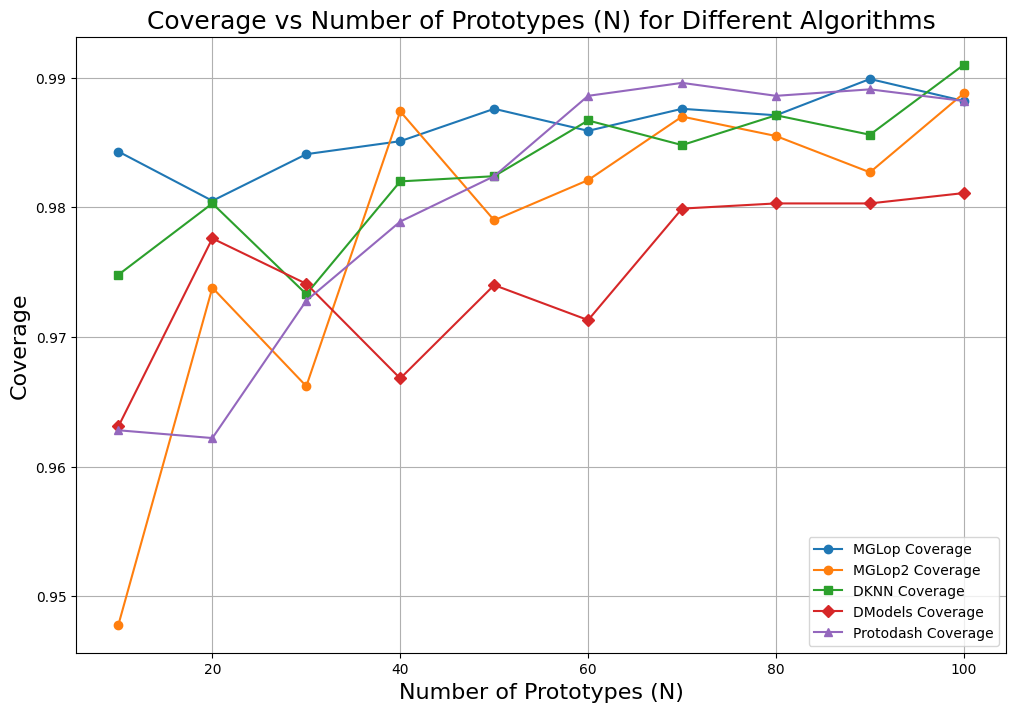

In [27]:
# mglop_cov=[]
# mglop2_cov=[]
# protodash_cov=[]
# dknn_cov=[]
# dmodels_cov=[]
# for i in range(len(all_protos_np)):
#     mglop_cov.append(coverage(list(all_protos_np[i].values())[0],N=10, bin=True, popularity=True))
#     mglop2_cov.append(coverage(list(all_protos_np[i].values())[1],N=10, bin=True, popularity=True))
#     dknn_cov.append(coverage(list(all_protos_np[i].values())[2],N=10, bin=True, popularity=True))
#     dmodels_cov.append(coverage(list(all_protos_np[i].values())[3],N=10, bin=True, popularity=True))
#     protodash_cov.append(coverage(list(all_protos_np[i].values())[4],N=10, bin=True, popularity=True))
   


plt.figure(figsize=(12, 8))
plt.plot(N_values, mglop_cov, marker='o', linestyle='-', label='MGLop Coverage')
plt.plot(N_values, mglop2_cov, marker='o', linestyle='-', label='MGLop2 Coverage')
plt.plot(N_values, dknn_cov, marker='s', linestyle='-', label='DKNN Coverage')
plt.plot(N_values, dmodels_cov, marker='D', linestyle='-', label='DModels Coverage')
plt.plot(N_values, protodash_cov, marker='^', linestyle='-', label='Protodash Coverage')

plt.xlabel("Number of Prototypes (N)", fontsize=16)
plt.ylabel("Coverage", fontsize=16)
plt.title("Coverage vs Number of Prototypes (N) for Different Algorithms", fontsize=18)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

##### Similarity of prototypes

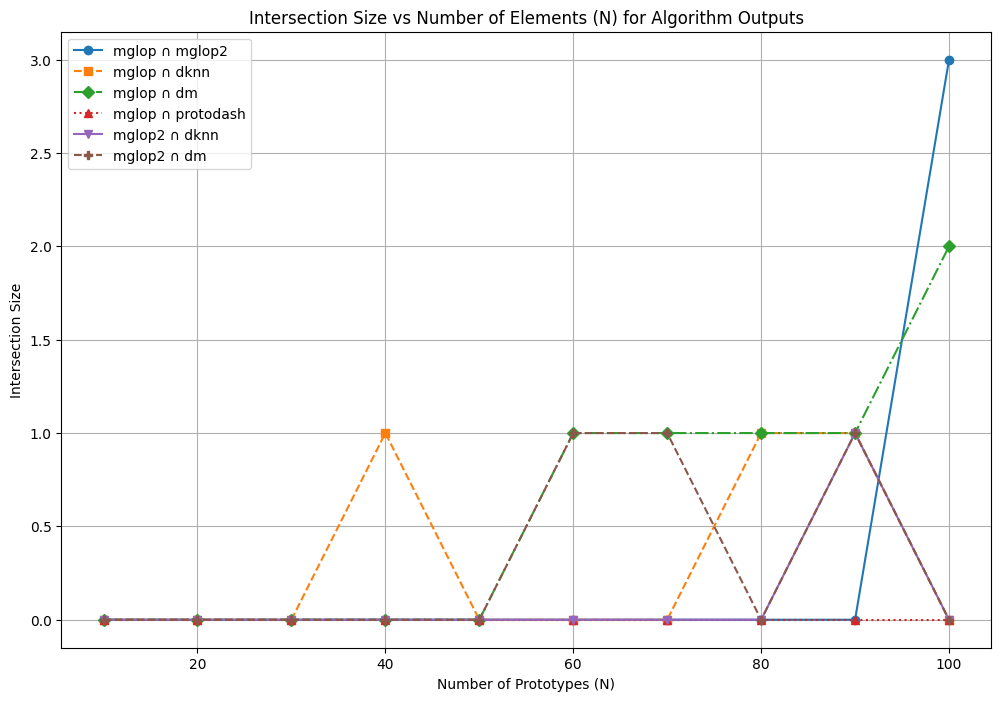

In [29]:
# Intersection

algorithms = ['mglop', 'mglop2', 'dknn', 'dm', 'protodash']
N_values = range(10, 101, 10)  # Increasing N values from 10 to 80
intersections = {f"{algo1} ∩ {algo2}": [] for i, algo1 in enumerate(algorithms) for algo2 in algorithms[i + 1:]}


# Extract intersections between algorithm outputs
for i, outputs in enumerate(all_protos):
    for j, algo1 in enumerate(algorithms):
        for algo2 in algorithms[j + 1:]:
            intersection_size = len(set(outputs[algo1]) & set(outputs[algo2]))
            intersections[f"{algo1} ∩ {algo2}"].append(intersection_size)

# Plotting the results
line_styles = ['-', '--', '-.', ':', '-', '--']
markers = ['o', 's', 'D', '^', 'v', 'P']

plt.figure(figsize=(12, 8))
for (label, sizes), linestyle, marker in zip(intersections.items(), line_styles, markers):
    plt.plot(N_values, sizes, linestyle=linestyle, marker=marker, label=label)

plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Intersection Size")
plt.title("Intersection Size vs Number of Elements (N) for Algorithm Outputs")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.grid(True)

# Save the plot as a PDF
# plt.savefig("Figures/intersection_plot.pdf", format="pdf")

# Show the plot
plt.show()

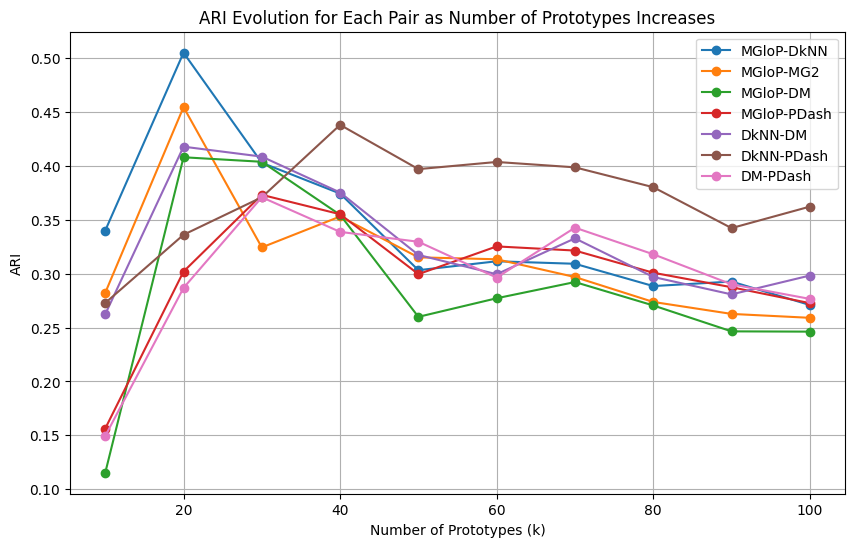

In [32]:
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist

def assign_clusters(X, prototypes):

    # Compute distance from each point to each prototype
    distances = cdist(X, prototypes, metric='euclidean')
    
    # Assign each point to the cluster with minimum distance
    labels = np.argmin(distances, axis=1)
    return labels

pairwise_aris = {
    "MGloP-DkNN": [],
    "MGloP-MG2": [],
    "MGloP-DM": [],
    "MGloP-PDash": [],
    "DkNN-DM": [],
    "DkNN-PDash": [],
    "DM-PDash": []
}

for i in range(len(all_protos_np)):
    labels1 = assign_clusters(test_embeddings, test_embeddings[list(all_protos_np[i].values())[0]])
    labels2 = assign_clusters(test_embeddings, test_embeddings[list(all_protos_np[i].values())[2]])
    labels3 = assign_clusters(test_embeddings, test_embeddings[list(all_protos_np[i].values())[3]])
    labels4 = assign_clusters(test_embeddings, test_embeddings[list(all_protos_np[i].values())[4]])
    labels5 = assign_clusters(test_embeddings, test_embeddings[list(all_protos_np[i].values())[1]])
    
    
    # Compute ARIs for all pairs
    ari_12 = adjusted_rand_score(labels1, labels2)
    ari_15 = adjusted_rand_score(labels1, labels5)
    ari_13 = adjusted_rand_score(labels1, labels3)
    ari_14 = adjusted_rand_score(labels1, labels4)
    ari_23 = adjusted_rand_score(labels2, labels3)
    ari_24 = adjusted_rand_score(labels2, labels4)
    ari_34 = adjusted_rand_score(labels3, labels4)
    
    # Append results
    pairwise_aris["MGloP-DkNN"].append(ari_12)
    pairwise_aris["MGloP-MG2"].append(ari_15)
    pairwise_aris["MGloP-DM"].append(ari_13)
    pairwise_aris["MGloP-PDash"].append(ari_14)
    pairwise_aris["DkNN-DM"].append(ari_23)
    pairwise_aris["DkNN-PDash"].append(ari_24)
    pairwise_aris["DM-PDash"].append(ari_34)

# Plot the ARI evolution for each pair
plt.figure(figsize=(10, 6))
for pair_name, ari_values in pairwise_aris.items():
    plt.plot(N_values, ari_values, marker='o', label=pair_name)

plt.title('ARI Evolution for Each Pair as Number of Prototypes Increases')
plt.xlabel('Number of Prototypes (k)')
plt.ylabel('ARI')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
np_file_path = "plot_data/all_protos_20pos.npy"
np.save(np_file_path, all_protos_np)

In [ ]:
all_protos_np=np.load('plot_data/all_protos_20pos.npy', allow_pickle=True)

In [34]:
# Generate data for all scores of all methods
mglop_ev=[]
mglop2_ev=[]
dmodels_ev=[]
protodash_ev=[]
dknn_ev=[]
for i in range(len(all_protos_np)):
    mglop_ev.append([nearest_medoid_accuracy(test_embeddings, mod_pred, list(all_protos_np[i].values())[0]), compute_prototype_silhouette_score(test_embeddings, list(all_protos_np[i].values())[0]), surrogate_fidelity(list(all_protos_np[i].values())[0])])
    mglop2_ev.append([nearest_medoid_accuracy(test_embeddings, mod_pred, list(all_protos_np[i].values())[1]), compute_prototype_silhouette_score(test_embeddings, list(all_protos_np[i].values())[1]), surrogate_fidelity(list(all_protos_np[i].values())[1])])
    dknn_ev.append([nearest_medoid_accuracy(test_embeddings, mod_pred, list(all_protos_np[i].values())[2]), compute_prototype_silhouette_score(test_embeddings, list(all_protos_np[i].values())[2]),surrogate_fidelity(list(all_protos_np[i].values())[2])])
    dmodels_ev.append([nearest_medoid_accuracy(test_embeddings, mod_pred, list(all_protos_np[i].values())[3]), compute_prototype_silhouette_score(test_embeddings, list(all_protos_np[i].values())[3]), surrogate_fidelity(list(all_protos_np[i].values())[3])])
    protodash_ev.append([nearest_medoid_accuracy(test_embeddings, mod_pred, list(all_protos_np[i].values())[4]), compute_prototype_silhouette_score(test_embeddings, list(all_protos_np[i].values())[4]), surrogate_fidelity(list(all_protos_np[i].values())[4])])


Epoch [1/100], Loss: 2.2958
Epoch [2/100], Loss: 1.9030
Epoch [3/100], Loss: 1.5501
Epoch [4/100], Loss: 1.2440
Epoch [5/100], Loss: 0.9880
Epoch [6/100], Loss: 0.7807
Epoch [7/100], Loss: 0.6174
Epoch [8/100], Loss: 0.4913
Epoch [9/100], Loss: 0.3951
Epoch [10/100], Loss: 0.3217
Epoch [11/100], Loss: 0.2654
Epoch [12/100], Loss: 0.2218
Epoch [13/100], Loss: 0.1875
Epoch [14/100], Loss: 0.1601
Epoch [15/100], Loss: 0.1379
Epoch [16/100], Loss: 0.1196
Epoch [17/100], Loss: 0.1044
Epoch [18/100], Loss: 0.0916
Epoch [19/100], Loss: 0.0807
Epoch [20/100], Loss: 0.0715
Epoch [21/100], Loss: 0.0636
Epoch [22/100], Loss: 0.0569
Epoch [23/100], Loss: 0.0511
Epoch [24/100], Loss: 0.0462
Epoch [25/100], Loss: 0.0419
Epoch [26/100], Loss: 0.0383
Epoch [27/100], Loss: 0.0351
Epoch [28/100], Loss: 0.0324
Epoch [29/100], Loss: 0.0300
Epoch [30/100], Loss: 0.0279
Epoch [31/100], Loss: 0.0261
Epoch [32/100], Loss: 0.0245
Epoch [33/100], Loss: 0.0231
Epoch [34/100], Loss: 0.0219
Epoch [35/100], Loss: 0

#### Faithfullnes

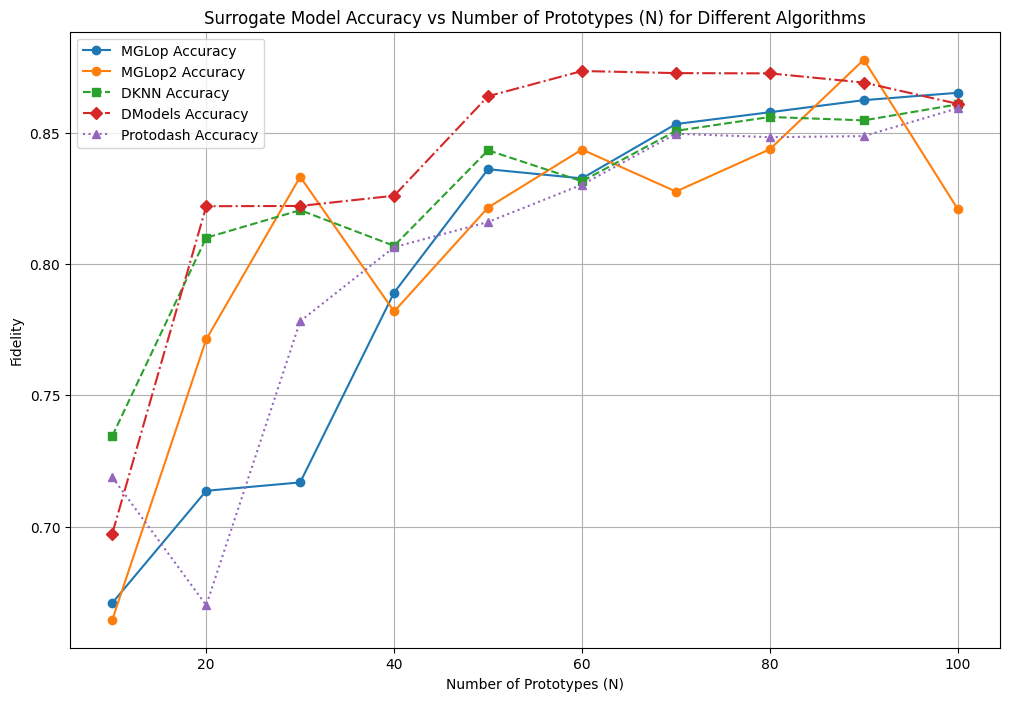

In [37]:
N_range=range(10,101,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, [item[2] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Accuracy')
plt.plot(N_range, [item[2] for item in mglop2_ev], marker='o', linestyle='-', label='MGLop2 Accuracy')
plt.plot(N_range, [item[2] for item in dknn_ev], marker='s', linestyle='--', label='DKNN Accuracy')
plt.plot(N_range, [item[2] for item in dmodels_ev], marker='D', linestyle='-.', label='DModels Accuracy')
plt.plot(N_range, [item[2] for item in protodash_ev], marker='^', linestyle=':', label='Protodash Accuracy')

plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Fidelity")
plt.title("Surrogate Model Accuracy vs Number of Prototypes (N) for Different Algorithms")
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

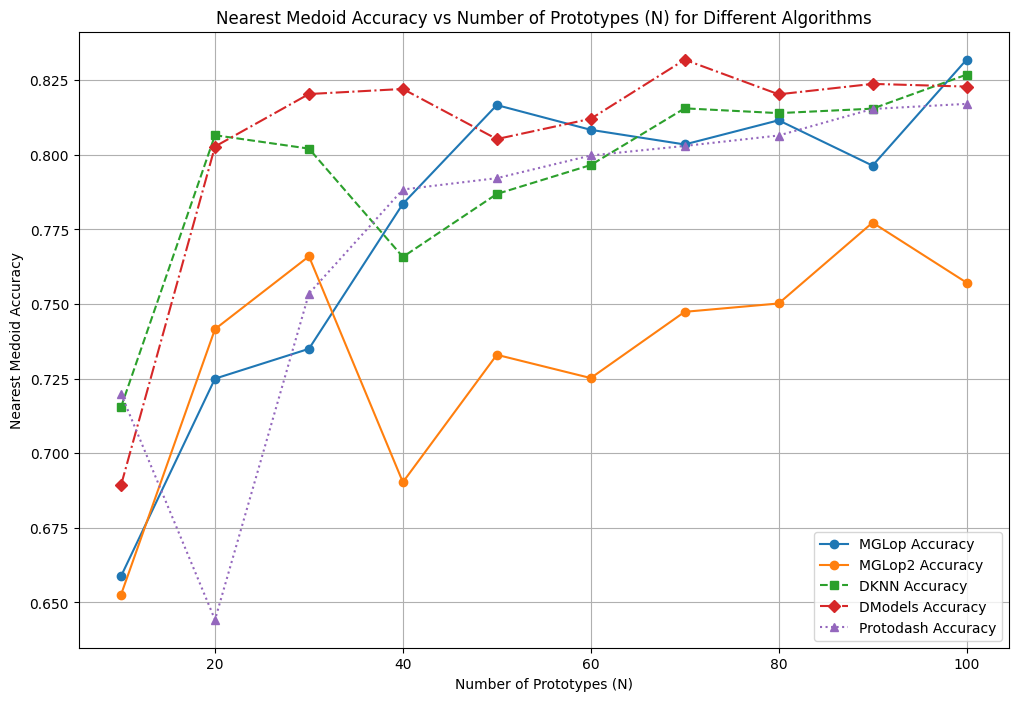

In [38]:
N_range=range(10,101,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, [item[0] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Accuracy')
plt.plot(N_range, [item[0] for item in mglop2_ev], marker='o', linestyle='-', label='MGLop2 Accuracy')
plt.plot(N_range, [item[0] for item in dknn_ev], marker='s', linestyle='--', label='DKNN Accuracy')
plt.plot(N_range, [item[0] for item in dmodels_ev], marker='D', linestyle='-.', label='DModels Accuracy')
plt.plot(N_range, [item[0] for item in protodash_ev], marker='^', linestyle=':', label='Protodash Accuracy')

plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Nearest Medoid Accuracy")
plt.title("Nearest Medoid Accuracy vs Number of Prototypes (N) for Different Algorithms")
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

#### Stability (Silhouette)

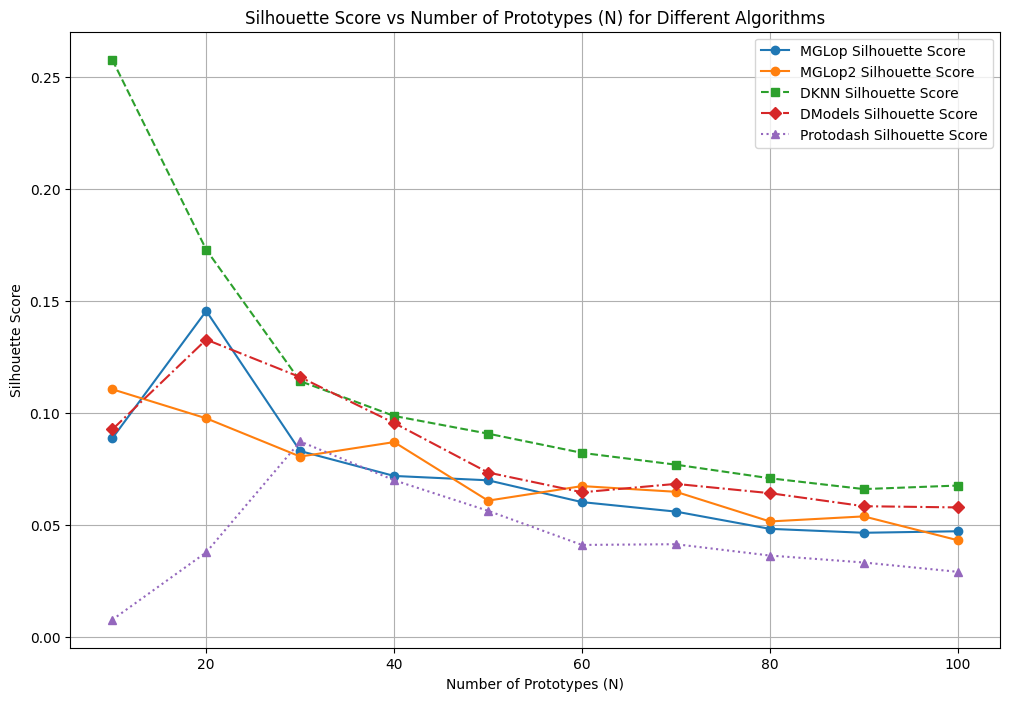

In [39]:
plt.figure(figsize=(12, 8))
plt.plot(N_range, [item[1] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Silhouette Score')
plt.plot(N_range, [item[1] for item in mglop2_ev], marker='o', linestyle='-', label='MGLop2 Silhouette Score')
plt.plot(N_range, [item[1] for item in dknn_ev], marker='s', linestyle='--', label='DKNN Silhouette Score')
plt.plot(N_range, [item[1] for item in dmodels_ev], marker='D', linestyle='-.', label='DModels Silhouette Score')
plt.plot(N_range, [item[1] for item in protodash_ev], marker='^', linestyle=':', label='Protodash Silhouette Score')

plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Prototypes (N) for Different Algorithms")
plt.legend()
plt.grid(True)
# plt.savefig("Figures/silhouette_score_plot.pdf", format="pdf")
plt.show()

#### Expected Inter-cluster similarity

In [44]:
len(avg_similarities4)

8

100%|██████████| 10/10 [01:08<00:00,  6.86s/it]


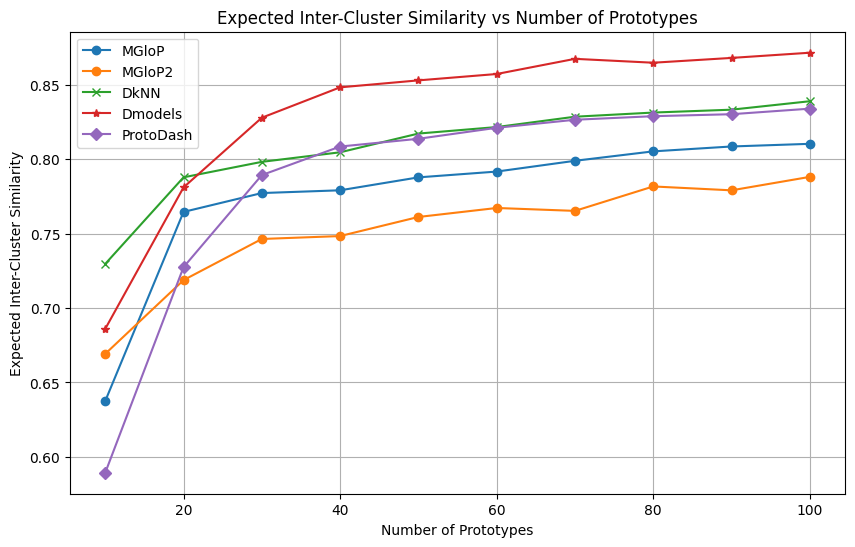

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


# Experiment with increasing number of prototypes
num_prototypes_list = range(10, 101, 10)
avg_similarities = []
avg_similarities1 = []
avg_similarities2 = []
avg_similarities3 = []
avg_similarities4 = []

for i in tqdm(range(10)):
    mglop=list(all_protos_np[i].values())[0]
    mglop2=list(all_protos_np[i].values())[1]
    dmodels=list(all_protos_np[i].values())[3]
    dknn=list(all_protos_np[i].values())[2]
    protodash=list(all_protos_np[i].values())[4]
    labels = cluster_by_prototypes(test_embeddings, mglop)
    labels4 = cluster_by_prototypes(test_embeddings, mglop2)
    labels1 = cluster_by_prototypes(test_embeddings, dknn)
    labels2 = cluster_by_prototypes(test_embeddings, dmodels)
    labels3 = cluster_by_prototypes(test_embeddings, protodash)
    avg_similarity = expected_inter_cluster_similarity(test_embeddings, labels)
    avg_similarity1 = expected_inter_cluster_similarity(test_embeddings, labels1)
    avg_similarity2 = expected_inter_cluster_similarity(test_embeddings, labels2)
    avg_similarity3 = expected_inter_cluster_similarity(test_embeddings, labels3)
    avg_similarity4 = expected_inter_cluster_similarity(test_embeddings, labels4)
    avg_similarities.append(avg_similarity)
    avg_similarities1.append(avg_similarity1)
    avg_similarities2.append(avg_similarity2)
    avg_similarities3.append(avg_similarity3)
    avg_similarities4.append(avg_similarity4)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_prototypes_list, avg_similarities, marker='o', label='MGloP')
plt.plot(num_prototypes_list, avg_similarities4, marker='o', label='MGloP2')
plt.plot(num_prototypes_list, avg_similarities1, marker='x', label='DkNN')
plt.plot(num_prototypes_list, avg_similarities2, marker='*', label='Dmodels')
plt.plot(num_prototypes_list, avg_similarities3, marker='D', label='ProtoDash')
plt.xlabel('Number of Prototypes')
plt.ylabel('Expected Inter-Cluster Similarity')
plt.title('Expected Inter-Cluster Similarity vs Number of Prototypes')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
covs

In [ ]:
aide_em[2].shape

In [ ]:
[i[0] for i in gx]

In [ ]:
np.where(cluster_labels == 1)[0]

## Printing anecdots

In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision.transforms.functional as F

def display_cifar10_images(indices, train=False):
    """
    Display CIFAR-10 images based on a list of indices and train/test flag.
    
    Args:
        indices (list of int): List of indices to display.
        train (bool): If True, load images from the training set. If False, use the test set.
    """
    # Define transformations for the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    # Load CIFAR-10 dataset (train or test)
    cifar10 = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)
    
    # Classes in CIFAR-10
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Number of images to display
    num_images = len(indices)
    
    # Set up a grid for the images
    plt.figure(figsize=(12, num_images * 2))  # Adjust figure size based on the number of images
    for i, index in enumerate(indices):
        image, label = cifar10[index]  # Get image and label at the given index
        
        # Resize the image for better display quality
        resized_image = F.resize(image, size=(128, 128))  # Resize to 128x128
        
        # Convert tensor to numpy format for visualization
        resized_image = resized_image.permute(1, 2, 0)  # Rearrange channels for matplotlib
        
        # Plot each image in a grid
        plt.subplot(1, num_images, i + 1)
        plt.imshow(resized_image)
        plt.title(f"{mod_pred[i]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example Usage
display_cifar10_images(protodash)  # Display test images
